
Here is Fashion MNIST training from scratch without using model.fit(...) method and keras.optimizers.
Main purpose of such approach: understanding NN training process

This example gives accuracy = 80% (+-0.5%) after 30 epoch on test dataset (please, check it).

**Task**: without changing Neural Network architecture reach accuracy on **test** dataset>= 90%. (i.e. model must contain only 3 trainable layers and they must be Fully Connected (Dense) as it is below, 
but you can add non-trainable parameters, decrease neurons number) 

**Auxiliary task**: create evaluation function to calculate accuracy for this classification problem, create your custom loss_function(y_true, y_pred), describe impact of each your improvement

It is prohibited to use: model.fit(...) and tf.keras.optimizers(but it is allowed to inherit from tf.optimizers.Optimizer and write your own optimizer). So, you have to implement train process and optimizer (like at this example).


Advices: You are able to change :


*   pre-processing
*   data augmentation
*   optimization process (SGD + momentum, Adam, RMSProp, etc)
*   regularization
*   learning rate schedule
*   loss function
*   add Normalization layers without training parameters
*   your approach

It is recommended to describe why your changes lead to the accuracy improvement

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import sklearn.metrics
import numpy as np
print(tf.__version__)

2.4.1


In [ ]:
train_data, info  = tfds.load("fashion_mnist", with_info = True, split = "train")
test_data = tfds.load("fashion_mnist", split = "test")

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteSIS2IW/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteSIS2IW/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",	"Bag",	"Ankle boot"]

In [ ]:
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams["figure.figsize"] = [10,10]
rcParams['xtick.labelbottom'] = False

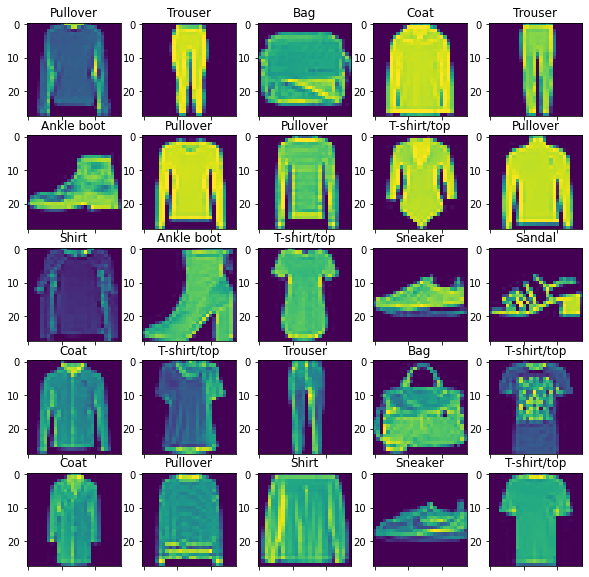

In [ ]:
for idx, elem in enumerate(train_data.take(25)):
  plt.subplot(5, 5, idx+1, title = names[elem['label'].numpy()] )
  plt.imshow(elem['image'][:,:,0])

In [ ]:
def preprocessing(data):
  x = data["image"]
  y = data["label"]
  return x, y

# NOT USED!!!
# Pixel Centering. Didn't proove useful.
def standartization(image, label):
  return tf.image.per_image_standardization(image), label

# Normalizarion increased to 86%
def normalization(image, label):
  return tf.math.divide(image, 256), label

# NOT USED!!!
# Magnifying edges. No improvement
def highlight(image, label):
  # image = tf.image.encode_jpeg(image)
  image = tf.image.adjust_contrast(image, 10)
  return image, label

# NOT USED!!!
# Augmentation is not useful. Worsens results. Too specific data and too little parameters in model.
def augmentation(image, label):
    image = tf.image.random_crop(image, [27, 27, 1])  # Crop and pad, basically moves image by 2 pixels up and down
    image = tf.image.pad_to_bounding_box(image, 1, 1, 28, 28)  # bad idea, images are all centered
    if(label != 7 and label != 9):
        image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0, 4)
    image = tf.image.random_jpeg_quality(image, 85, 100)

    return image, label

# Detect edge using Sobel transformation. Very useful.(up to 88%)
def edge_detection(image, label):
  image = tf.expand_dims(image, 0)
  image = tf.dtypes.cast(image, tf.float32)
  grad_components = tf.image.sobel_edges(image)
  grad_components = tf.squeeze(grad_components)
  image = tf.math.reduce_sum(grad_components, axis=-1)  # sum vertical and horizontal
  image = tf.expand_dims(image, -1)
  image = tf.math.abs(image) 
  return image, label


def flatten(image, label):
  return tf.reshape(image, [-1]), label

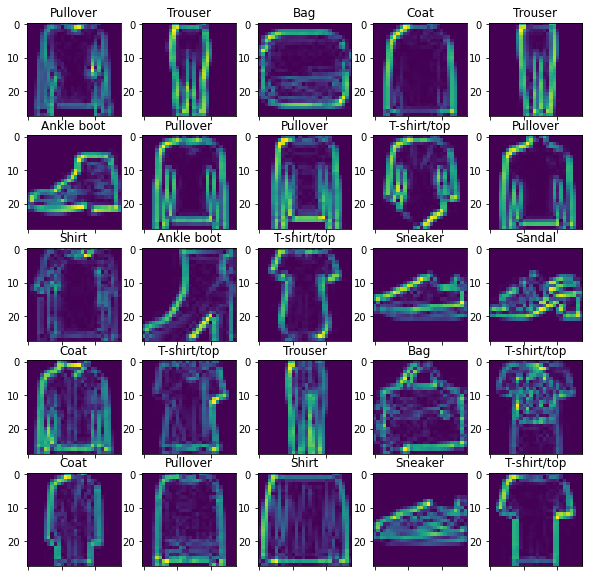

In [ ]:
train_data_pre = train_data.map(preprocessing)
test_data_pre = test_data.map(preprocessing)

train_data_pre = train_data_pre.map(edge_detection).map(normalization).cache().repeat(3)
test_data_pre = test_data_pre.map(edge_detection).map(normalization)

for idx, elem in enumerate(train_data_pre.take(25)):
  plt.subplot(5, 5, idx+1, title = names[elem[1].numpy()] )
  plt.imshow(elem[0][:,:,0])


#flatten
train_data_pre = train_data_pre.map(flatten)
test_data_pre = test_data_pre.map(flatten)

# changed batch size = 512
# Model trains slower, but finds minimum faster
batch_size = 512
train_data_pre = train_data_pre.batch(batch_size)
test_data_pre = test_data_pre.batch(10000)

In [ ]:
# You are able to modify base_model(), but requirements:
# 1)Trainable params <= 55,050
# 2)Model contains only 3 fully-connected trainable layers.
def base_model():
  inputs = tf.keras.Input(shape=(784,))
  x = tf.keras.layers.Dropout(0.2)(inputs) # dropping unused pixels. Very helpfull(88%).
  x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l1')(x)
  # x = tf.keras.layers.Dropout(0.2)(x) # Faster generalization. Still being used in validation with Eager mode?(84-85%).
  x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer='l1')(x) #L1 regularization is definately useful(up to 86%). L2 not so much.
  # x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

model = base_model()
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


TODO: write your own imlementation of the **loss function**, 
i.e. implement **loss_func(y_true, y_pred)** and use it  
instead of tf.keras.losses.SparseCategoricalCrossentropy()

Adam optimizer. Gives one way improvement. Up to 84-85% on 30 epochs.

In [ ]:
# Confustion matrix shows that "Shirt" is being recognized poorly. 
# Implemented Weighted Loss function to make correction
# Not really useful. Other classes loose drastically if forcing to keep "Shirt" high.

# loss_weights = tf.Variable([1, 1, 1, 1, 1, 1, 3, 1, 1, 1], dtype=tf.float32)
loss_weights = tf.Variable([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=tf.float32)
loss_object = WeightedCategoricalCrossEntropy(loss_weights)
# optimizer = SGDmomentum(learning_rate=0.01)
optimizer = AdamOptimizer()

@tf.function
def train_step(x, y):
  # lr = 0.001
  with tf.GradientTape() as tape:
    pred = model(x, training=True)
    loss = loss_object(y, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    # Using optimizer here
    optimizer.apply_gradients(gradients)
    return loss


In [ ]:
epoch_num = 30
for epoch in range(epoch_num):
   
    losses = []
    for step, (x, y) in enumerate(train_data_pre):
        losses.append(train_step(x, y))

    # val_accuracy = eval(test_data_pre)  # using train data as validation data. No way to split train data in tfds???
    print("EPOCH {}:".format(epoch))  
    epoch_loss = calc_epoch_loss(losses)  # epoch loss
    # evaluating test_dataset with scikit.metrix.classification_report
    # returns precision, recall, f1 and support. Also calculates avg accuracy.
    eval_confusion(test_data_pre) 
    print("loss: {}".format(epoch_loss))


EPOCH 0:
(10000,)
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1025
           1       0.97      0.95      0.96      1023
           2       0.81      0.75      0.78      1085
           3       0.82      0.89      0.85       931
           4       0.84      0.70      0.77      1198
           5       0.95      0.93      0.94      1023
           6       0.53      0.73      0.61       726
           7       0.92      0.92      0.92      1002
           8       0.96      0.95      0.96      1005
           9       0.93      0.95      0.94       982

   micro avg       0.86      0.86      0.86     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.87      0.86      0.86     10000
 samples avg       0.86      0.86      0.86     10000

loss: 0.5239400487731803
EPOCH 1:
(10000,)
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1005
           1     

# Conclusion
Without changing NN architecture I was able to boost it's validation accuracy on "test_data_pre" to 90%. 

## Changes that improved accuracy.

Successfull change No 1: 
**Implemented Adam optimizer.** Choice was made to implement this optimizer due to its success in big variety of problems. This change introduced stable loss reduction and introduced stable boost for accuracy. Up to **84%** .

Successfull change No 2: 
**Data normalization.** Images are normalized by scaling values to ragne (0..1) with division by 255. Increased accuracy to **85%**

Successfull change No 3: 
**Data preprocessing and feature engineering.** I tried several different methods to make data more "understandable" for given NN. Performing edge detection with Sobel transformation appeared to be very useful. Accuracy increased up to whole **87-88%**

Successfull change No 4:
**Regularization.** L1 regularization is useful in current problem. Another very interesting improvement was to **introduce Dropout regularization right after Input layer**. What happened is that not useful pixels didn't introduce changes. Regularization boosted performance to **89-90%**

Successfull change No 4:
Training model with **bigger batch** slowed times before reaching 89%, but provided more stability in order to reach **90%** of accuracy.

## Things I tried that didn't work out

Augmentation: I tried different ways of augmentation. None of them improved test accuracy. Quite the opposite, due to specificality of the data (images are centered, same quality and are pointed in one direction), it only decreased models ability to fit the data. 

SGD with momentum: another popular optimization that "rivals" with Adam, because it is able to reach bigger minimum, usually. SGD didn't give much more improvement. Way slower than Adam.

KLDivergence loss function: performed worse than Categorical Cross Entropy for -1%.

Weighted Loss funciton: If you look at model precision you can notice that it performs very badly on "Shirt" classification. If with weighted loss I could force model to "pay more attention" to this class. But "Shirt" classification improvement decreases overal model's performance on other classes.

Regularization: using L2 regularization didn't improve accuracy. Using Dropout in between dense layers only decreased accuracy.

# TO DO : calculate accuracy on the test dataset 'test_data_pre'

**eval()** - simply calculates percentage of correct predictions.

In [ ]:
def eval(data):
  total = []
  count = 0
  for step, (x,y) in enumerate(data):
    count += 1
    pred = model(x, training=False)
    # get element wise equality between max values(most probable) and expected
    pred = tf.math.equal(tf.argmax(pred, 1), y)
    count = tf.math.count_nonzero(pred)
    # get average
    percent = tf.math.divide(count, pred.shape)
    # append batch accuracy to total
    total.append(percent)
  # convert to numpy
  total = [x.numpy()[0] for x in total]
  total_accuracy = sum(total)/len(total)
  return total_accuracy

**eval_confusiton()** - prints classification report with: precision, recall, f1, support and accuracy

In [ ]:
def eval_confusion(data):
    total = []
    count = 0
    for step, (x,y) in enumerate(data):
        count += 1
        pred = model(x, training=False)
        predicted_categories = tf.argmax(pred, axis=1)
        total_pred = predicted_categories.numpy()
        total_true = y.numpy()
    print(total_true.shape)
    total_pred_one_hot = np.zeros((len(total_pred), 10))
    total_pred_one_hot[np.arange(len(total_pred)), total_pred] = 1
    total_true_one_hot = np.zeros((len(total_true), 10))
    total_true_one_hot[np.arange(len(total_true)), total_true] = 1

    print(sklearn.metrics.classification_report(total_pred_one_hot, total_true_one_hot))

Nothing interesting here

In [ ]:
def calc_epoch_loss(losses):
  epoch_loss = [x.numpy() for x in losses]
  epoch_loss = sum(epoch_loss) / len(epoch_loss)
  return epoch_loss

AdamOptimizer with default parameters recommended for this optimizer. Calculates updates and applies them inside apply_gradient(). Reaches minimum in reasonable amount of epochs. **Proven to be better in current problem.**

In [ ]:
class AdamOptimizer(tf.optimizers.Optimizer):
    def __init__(self, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.m = {}
        self.u = {}
        self.t = tf.Variable(0.0, trainable=False)

        for v in model.trainable_variables:
            self.m[v.ref()] = tf.Variable(tf.zeros(tf.shape(v)), trainable=False)
            self.u[v.ref()] = tf.Variable(tf.zeros(tf.shape(v)), trainable=False)

    def apply_gradients(self, gradients):
        t = self.t.assign_add(1.0)

        new_weights = []
        for v, grad in zip(model.trainable_variables, gradients):
            m = self.m[v.ref()].assign(self.beta1 * self.m[v.ref()] + (1 - self.beta1) * grad)
            u = self.u[v.ref()].assign(self.beta2 * self.u[v.ref()] + (1 - self.beta2) * grad * grad)
            m_hat = m / (1 - tf.pow(self.beta1, t))
            u_hat = u / (1 - tf.pow(self.beta2, t))
            update = -self.alpha * m_hat / (tf.sqrt(u_hat) + self.epsilon)
            new_weights.append(v.assign_add(update))

        for v, w in zip(model.trainable_variables, new_weights):
            v.assign(w)
        # return tf.group(*update_ops)

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "alpha": self._serialize_hyperparameter("alpha"),
            "beta1": self._serialize_hyperparameter("beta1"),
            "beta2": self._serialize_hyperparameter("beta2"),
            "epsilon": self._serialize_hyperparameter("epsilon")
        }

Stochastic Gradient Descent implementation with Momentum. Current updates are based on the previous updates. Able to reach better minimum. Although requires more EPOCHS. **Proven to be worse than Adam in current problem.**

In [ ]:
class SGDmomentum(tf.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001,momentum=0.3, prev_change=0, beta = 0.9):
        self.learning_rate = learning_rate
        self.beta = beta
        self.m = {}
        for v in model.trainable_variables:
            self.m[v.ref()] = tf.Variable(tf.zeros(tf.shape(v)), trainable=False)

    def set_learning_rate(self, learning_rate):
        self.learning_rate = learning_rate

    def apply_gradients(self, gradients):

        new_weights = []
        for v, grad in zip(model.trainable_variables, gradients):
            # v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
            update = self.m[v.ref()].assign(self.beta*self.m[v.ref()] + (1-self.beta)*grad)
            update = -self.learning_rate*update
            new_weights.append(update)

        for v, w in zip(model.trainable_variables, new_weights):
            v.assign_add(w)

Custom loss function. It is the Categorical Cross Entropy with Weights. Weights can be used to force better fitting for the particular classes. Although in current problem adding weights to loss calculation didn't increase total accuracy. **Proven to be better in current problem.**

In [ ]:
class WeightedCategoricalCrossEntropy(tf.keras.losses.Loss):

    def __init__(self, weights = tf.constant([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=tf.float32)):
        super().__init__()
        self.weights = weights

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.one_hot(y_true, 10)
        y_true = tf.cast(y_true, y_pred.dtype)

        y_pred = tf.clip_by_value(y_pred, 0.001, 1)
        y_pred /= tf.math.reduce_sum(y_pred, axis=-1, keepdims=True)
        weights_sparse = tf.expand_dims(self.weights, axis=0)
        weights_sparse = tf.tile(weights_sparse, [y_pred.shape[0], 1])
        cross = tf.math.multiply(y_true, tf.math.log(y_pred))
        cross = tf.math.multiply(weights_sparse, cross)
        loss = -tf.math.reduce_sum(cross, -1)

        return loss

Alternate loss function. Would give 88% accuracy if used. **Proven to be worse in current problem.**

In [ ]:
class KLDivergence(tf.keras.losses.Loss):

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.one_hot(y_true, 10)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred /= tf.math.reduce_sum(y_pred, axis=-1, keepdims=True)


    y_pred = tf.clip_by_value(y_pred, 0.001, 1)
    y_true = tf.clip_by_value(y_true, 0.001, 1)
    # calc
    loss = tf.math.multiply(y_true, tf.math.log(tf.math.divide(y_true, y_pred)))
    loss = tf.math.reduce_sum(loss, -1)
    return loss